In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, RandomUniform
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import os
import matplotlib.pyplot as plt

In [21]:
def read_all_images():

    folder='D:\dersler\cng483\Proje3\CNG483Project 3\Database'
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img=np.array(img)
            img=img.astype('float32')
            images.append(img)

    return images

In [22]:
def get_iris_crop():

    images=read_all_images()
    resultimages=[]
    img_labels=[]
    def add_iris_to_array(u,j):
        X=int(u[0])
        Y=int(u[1])
        R=int(u[2])

        result = images[j][X-R:X+R,Y-R:Y+R]
        result = cv2.resize(result,(128,128))
        resultimages.append(result)

    for i in range(len(images)):

        file = open('D:\dersler\cng483\Proje3\CNG483Project 3\Database/Parameters.txt', "r")
        lines = file.readlines()[2:]


        if(i%8==0):

            for z in range(8):

                if(z<4):

                    if(z==0 or z==1):
                        u=lines[i+z].rstrip('\n').split(',')[1:]
                        name = lines[i+z].rstrip('\n').split(',')[0]
                        add_iris_to_array(u,i+z)
                    else: 
                        u=lines[i+z+2].rstrip('\n').split(',')[1:]
                        name = lines[i+z+2].rstrip('\n').split(',')[0]                        
                        add_iris_to_array(u,i+z)

                else:

                    if((z-2)==2 or (z-2)==3):
                        u=lines[i+(z-2)].rstrip('\n').split(',')[1:]
                        name = lines[i+(z-2)].rstrip('\n').split(',')[0]
                        add_iris_to_array(u,i+z)
                    else  : 
                        u=lines[i+z].rstrip('\n').split(',')[1:]
                        name = lines[i+z].rstrip('\n').split(',')[0]
                        add_iris_to_array(u,i+z)
                img_labels.append(name)
    img_labels=np.array(img_labels)
    resultimages = np.array(resultimages)

    return img_labels,resultimages


In [23]:
def determine_labels(img_names):
    count=1
    labels=[]
    for i in range(0,len(img_names),8):
        label=img_names[i:i+8]
        
        for j in range(8):
            if(j==0 or j==1 or j==4 or j==5):
                labels.append(count)
            else:
                labels.append(count+1)
        count+=2
    labels=np.array(labels)
    return labels



In [24]:
def plotHistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [25]:
def CNN(X,y):
    X=X.reshape(-1, 128, 128, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50,stratify=y, shuffle=True, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50,stratify=y_train, shuffle=True, random_state=1)
    # building a linear stack of layers with the sequential model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128,128,1)))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(401, activation='softmax'))
    print(model.summary())
	# compile model
    opt = RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    batches = 256
    epochs=150
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batches, verbose=1)
    plotHistory(model.history)

    _, validation_accuracy = model.evaluate(X_val, y_val, batch_size=batches)
    _, test_accuracy = model.evaluate(X_test, y_test, batch_size=batches)

    print('Validation Accuracy: %f, Test Accuracy: %.3f'  % (validation_accuracy*100, test_accuracy*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

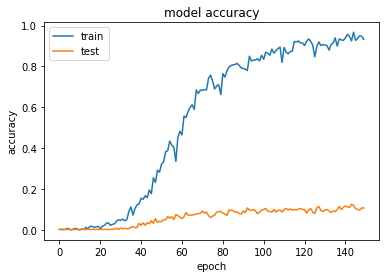

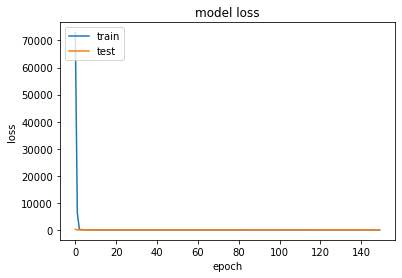

4/4 [==============================] - 1s 301ms/step - loss: 58.6868 - acc: 0.1163
Validation Accuracy: 10.750000, Test Accuracy: 11.625


In [26]:
img_names,img_crops= get_iris_crop() # Read all data and get the iris part, image_names-> names of the images, img_crops-> preprocessed images
img_labels=determine_labels(img_names) # Label the images based on their names



CNN(img_crops,img_labels)